In [404]:
import sys
sys.path.append("code")

# %load_ext autoreload

In [405]:
from datetime import datetime

import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sb

In [406]:
from plotting import format_plot, save_plot
from constants import JULIAN_DAY
from spice_tools import as_et, as_utc, rotate_frame
from simulation_tools import load_simulation_results
from util import cart2track, cart2spher

In [407]:
# datafile = "../results/test_albedo/albedo_i=0.txt"
# datafile = "../results/test_albedo/albedo_i=45.txt"
# datafile = "../results/test_albedo/albedo_i=90.txt"
# datafile = "../results/test_albedo/emissivity_i=90.txt"

frame = "J2000"

# Center cap only
# datafile = "../results/test_albedo/albedo_lageos_1.txt"

# {3}
# datafile = "../results/test_albedo/albedo_lageos_2.txt"

# {24, 24, 24}
# datafile = "../results/test_albedo/albedo_lageos_3.txt"

# {6, 12}
# datafile = "../results/test_albedo/albedo_lageos_4.txt"

# {6, 12} at epoch
datafile = "../results/test_albedo/albedo_emissivity_lageos_1.txt"

# {6, 12} + 1/4 year
# datafile = "../results/test_albedo/albedo_emissivity_lageos_2.txt"

# {6, 12} + 2/4 year
# datafile = "../results/test_albedo/albedo_emissivity_lageos_3.txt"

# {6, 12} + 3/4 year
# datafile = "../results/test_albedo/albedo_emissivity_lageos_4.txt"

# {6, 12} at epoch with kepler ephemeris
# datafile = "../results/test_albedo/albedo_emissivity_lageos_5.txt"

# {6, 12} at epoch ECLIPJ2000
# datafile = "../results/test_albedo/albedo_emissivity_lageos_6.txt"
# frame = "ECLIPJ2000"

# static 2000 at epoch
# datafile = "../results/test_albedo/albedo_emissivity_lageos_7.txt"

# {6, 12} at epoch with constant a + e
# datafile = "../results/test_albedo/albedo_emissivity_lageos_8.txt"

def load_and_tf(datafile, frame):
    with open(datafile) as f:
        rows = []
        for line in f.readlines():
            if line:
                rows.append([float(x) for x in line.split(", ")])

    df = pd.DataFrame(rows, columns=[
        "t", "pos_x", "pos_y", "pos_z", "vel_x", "vel_y", "vel_z", "acc_x", "acc_y", "acc_z",
        "albedo", "irr"
    ])

    def tf(row):
        acc = row[["acc_x", "acc_y", "acc_z"]].to_numpy()
        pos = row[["pos_x", "pos_y", "pos_z"]].to_numpy()
        vel = row[["vel_x", "vel_y", "vel_z"]].to_numpy()

        row["acc_radial"], row["acc_along"], row["acc_cross"] = cart2track(acc, vel, pos)

        # pos_spher = cart2spher(*(rotate_frame(frame, "IAU_Earth", row["t"]) @ pos))
        pos_spher = cart2spher(*pos)
        row["lat"] = np.degrees(np.pi / 2 - pos_spher[1])
        row["lon"] = np.degrees(pos_spher[2])

        return row

    return df.iloc[:, :].apply(tf, axis=1)

df = load_and_tf(datafile, frame)
df

,t,pos_x,pos_y,pos_z,vel_x,vel_y,vel_z,acc_x,acc_y,acc_z,albedo,irr,acc_radial,acc_along,acc_cross,lat,lon
0,-721848000.0,-7530900.0,9754200.0,-9683.28,1510.40,1178.85,5342.98,-1.253790e-10,1.623920e-10,6.805560e-13,0.195033,82.5511,2.051604e-10,7.919818e-13,-2.852000e-13,-0.045022,127.670561
1,-721848000.0,-7510310.0,9769960.0,62629.10,1532.09,1150.70,5342.90,-1.249940e-10,1.625990e-10,1.936790e-12,0.195385,82.5257,2.050973e-10,8.414754e-13,-3.032595e-13,0.291191,127.550004
2,-721848000.0,-7489430.0,9785340.0,134939.00,1553.72,1122.50,5342.62,-1.246020e-10,1.627960e-10,3.192100e-12,0.195767,82.4989,2.050305e-10,8.908428e-13,-3.215141e-13,0.627398,127.429449
3,-721848000.0,-7468260.0,9800350.0,207244.00,1575.29,1094.26,5342.12,-1.242020e-10,1.629830e-10,4.446390e-12,0.196179,82.4706,2.049594e-10,9.403506e-13,-3.392973e-13,0.963600,127.308855
4,-721848000.0,-7446790.0,9814960.0,279540.00,1596.79,1065.97,5341.42,-1.237950e-10,1.631610e-10,5.699510e-12,0.196621,82.4408,2.048856e-10,9.899623e-13,-3.565853e-13,1.299790,127.188257
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2996,-721808000.0,-7617520.0,9683840.0,-224484.00,1442.12,1266.24,5341.95,-1.269060e-10,1.613290e-10,-3.064450e-12,0.194174,82.6004,2.052830e-10,6.353311e-13,-2.287782e-13,-1.043805,128.189363
2997,-721808000.0,-7597850.0,9700790.0,-152181.00,1464.06,1238.28,5342.50,-1.265440e-10,1.615670e-10,-1.806530e-12,0.194433,82.5796,2.052316e-10,6.848616e-13,-2.468986e-13,-0.707585,128.068747
2998,-721808000.0,-7577890.0,9717360.0,-79872.40,1485.94,1210.28,5342.83,-1.261740e-10,1.617950e-10,-5.491470e-13,0.194723,82.5574,2.051760e-10,7.345318e-13,-2.645684e-13,-0.371367,127.948179
2999,-721808000.0,-7557630.0,9733550.0,-7560.60,1507.77,1182.23,5342.96,-1.257970e-10,1.620130e-10,7.075820e-13,0.195042,82.5337,2.051168e-10,7.840433e-13,-2.826284e-13,-0.035153,127.827607


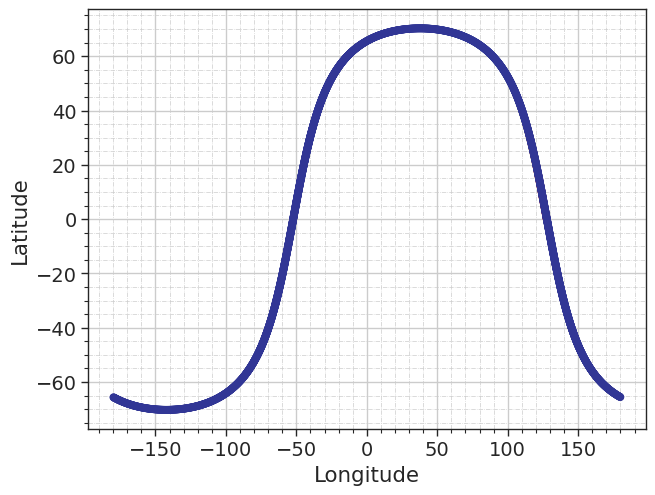

In [408]:
plt.scatter(df["lon"], df["lat"], color=plt.cm.RdYlBu(range(len(df.index))))
plt.xlabel("Longitude")
plt.ylabel("Latitude")
format_plot()

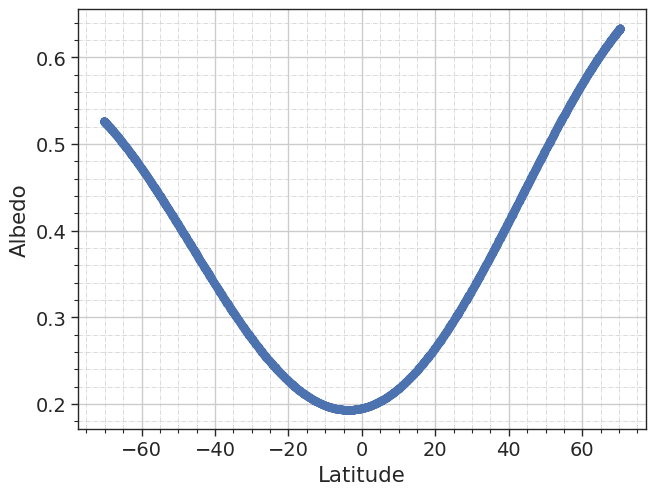

In [409]:
plt.scatter(df["lat"], df["albedo"])
plt.xlabel("Latitude")
plt.ylabel("Albedo")
format_plot()

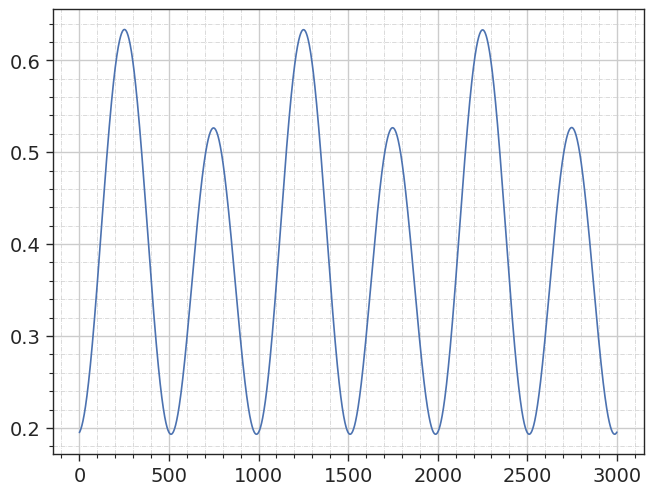

In [410]:
plt.plot(df["albedo"])
format_plot()

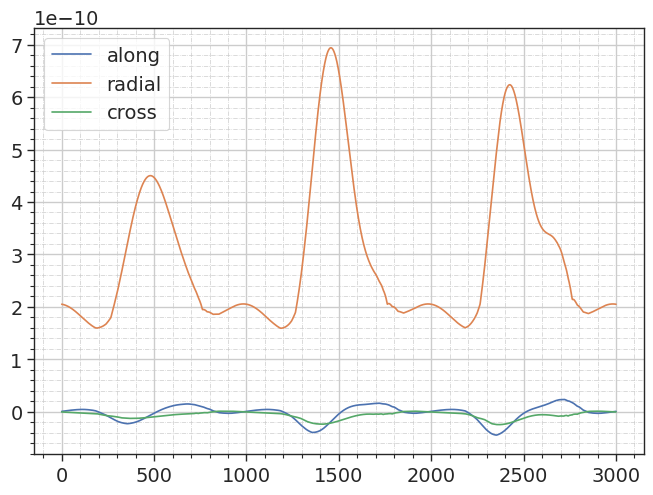

In [411]:
plt.plot(df["acc_along"], label="along")
plt.plot(df["acc_radial"], label="radial")
plt.plot(df["acc_cross"], label="cross")
plt.legend()
# plt.ylim([0, plt.ylim()[1]])
format_plot()

Text(0.5, 0, 'Albedo')

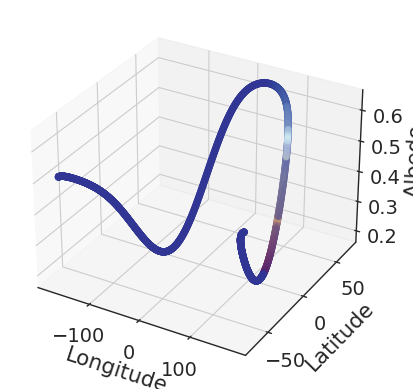

In [412]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(
    df["lon"], df["lat"], df["albedo"],
    color=plt.cm.RdYlBu(range(len(df.index))))

ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_zlabel("Albedo")